# Starter code: network for Irises in Pytorch


In the following cells a feedforward neural network has been implemented with the aid of PyTorch and its autograd mechanism. Please study the code - many network implementations follow a similar pattern.

The provided network trains to nearly 100% accuracy on Iris using Batch Gradient Descent.

# Assignment 4

**Submission deadline:** 

**normal problems last lab session before or on Wednesday, 30.11.18**

**bonus problems last lab session before or on Wednesday, 7.12.18**


**Points: 11 + 5 bonus points**


## Downloading this notebook

This assignment is an Colab/Jupyter notebook. Download it by cloning https://github.com/janchorowski/nn_assignments. Follow the instructions in its README for instructions.

Please do not hesitate to use GitHub’s pull requests to send us corrections!

If you use Colab please make sure to have a GPU runtime (```Runtime -> Change runtime type -> Hardware Accelarater = GPU```)

In [0]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport
![ -e cifar.npz ] || gdown 'https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR' -O cifar.npz
![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

Downloading...
From: https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR
To: /content/cifar.npz
185MB [00:01, 141MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU
To: /content/mnist.npz
55.4MB [00:00, 152MB/s] 
tcmalloc: large alloc 1073750016 bytes == 0x556cc347a000 @  0x7f05d00a32a4 0x556c6b78cf18 0x556c6b880a85 0x556c6b7a04ca 0x556c6b7a5232 0x556c6b79dd0a 0x556c6b7a55fe 0x556c6b79dd0a 0x556c6b7a55fe 0x556c6b79dd0a 0x556c6b7a55fe 0x556c6b79dd0a 0x556c6b7a5c38 0x556c6b79dd0a 0x556c6b7a55fe 0x556c6b79dd0a 0x556c6b7a55fe 0x556c6b7a5232 0x556c6b7a5232 0x556c6b79dd0a 0x556c6b7a5c38 0x556c6b7a5232 0x556c6b79dd0a 0x556c6b7a5c38 0x556c6b79dd0a 0x556c6b7a5c38 0x556c6b79dd0a 0x556c6b7a55fe 0x556c6b79dd0a 0x556c6b79d629 0x556c6b7ce61f


In [0]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Getting to know PyTorch

From now on, we will use [pytorch](https://pytorch.org/) to implement neural networks.

Good introductions are the [60-minute tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) and [pytorch examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).


Pytorch has a set of modules to build neural networks. However, for simplicity, this assignment will use a custom, simple neural network code.

In [0]:
import numpy as np
import time
import torch
import torch.nn.functional as F


class Layer(object):
    
    def __init__(self):
        self.training = False
    
    def train_mode(self):
        """Put layer into training mode.
        
        This is useful for e.g. Dropout.
        """
        self.training=True
    
    def eval_mode(self):
        """Put layer into evalation mode.
        
        This is useful for e.g. Dropout.
        """
        self.training=False
    
    def to_device(self, device):
        """Move this layer's parameters to thie given device (cpu/cuda).
        """
        
        pass
    
    @property
    def parameters(self):
        return []
    
    def __repr__(self):
        param_s = ', '.join(['%s%s' % (n, tuple(p.size())) 
                                 for (n,p) in self.parameters])
        if not param_s:
            return '  %s with no params' % (self.__class__.__name__)
        else:
            return '  %s with params: %s' % (self.__class__.__name__, param_s)
    

class AffineLayer(Layer):
    def __init__(self, num_in, num_out, dropout= False):
        super(AffineLayer,self).__init__()
        self.W = torch.empty(num_in, num_out, dtype=torch.float32, requires_grad=True)
        self.b = torch.empty(1, num_out, dtype=torch.float32, requires_grad=True)
        self.dropout = dropout
    
    @property
    def parameters(self):
        return [('W', self.W), ('b', self.b)]
    
    def forward(self, x):
        if self.dropout:
            return (torch.nn.functional.dropout(x, p=0.5, training=self.training, inplace=False)).mm(self.W) + self.b
        return (x.view(x.size(0),-1)).mm(self.W) + self.b
    
    def to_device(self, device):
        with torch.no_grad():
            self.W = self.W.to(device).requires_grad_()
            self.b = self.b.to(device).requires_grad_()

    
class TanhLayer(Layer):
    def forward(self, x):
        return F.tanh(x)

    
class  ReLULayer(Layer):
    def forward(self, x):
        return F.relu(x)
    
class RealConvLayer(Layer):
    
    def __init__(self, in_channels, out_channels, kernel_size, x_dim, y_dim, stride=1, padding=0):
        self.W = torch.empty(out_channels, in_channels,kernel_size,kernel_size, dtype=torch.float32, requires_grad=True)
        self.b = torch.empty(out_channels, dtype=torch.float32, requires_grad=True)
        self.stride = stride
        self.padding = padding
        self.in_channels = in_channels
        self.x_dim = x_dim
        self.y_dim = y_dim
    
    @property
    def parameters(self):
        return [('W', self.W), ('b', self.b)]
    
    #torch.nn.functional.conv1d(input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1) 
    def forward(self, x):
        return (torch.nn.functional.conv2d(x, self.W, self.b, self.stride, self.padding))
    
    def to_device(self, device):
        with torch.no_grad():
            self.W = self.W.to(device).requires_grad_()
            self.b = self.b.to(device).requires_grad_()
            
#input – input tensor of shape (minibatch×in_channels×iH×iW)
#weight – filters of shape (out_channels×in_channels/groups×kH×kW)
#bias – optional bias of shape (out_channels). Default: None
#stride – the stride of the convolving kernel. Can be a single number or a one-element tuple (sW,). Default: 1
#padding – implicit zero paddings on both sides of the input. Can be a single number or a one-element tuple (padW,). Default: 0
#dilation – the spacing between kernel elements. Can be a single number or a one-element tuple (dW,). Default: 1
#groups – split input into groups, in_channels should be divisible by the number of groups. Default: 1
            
            
class ConvvLayer(Layer):
    def __init__(self,in_channels,out_channels,kernel_size,x_dim,y_dim,stride=1, padding=0 ):
        self.in_c = in_channels
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.conv2 = torch.nn.Conv2d(in_channels, out_channels, kernel_size,stride=stride, padding=padding).cuda()
        

    
    def forward(self, x):
        return self.conv2(x.view(x.size(0),self.in_c,self.x_dim,self.y_dim))

    
#torch.nn.functional.max_pool2d(input, kernel_size, stride=None, padding=0, dilation=1, ceil_mode=False, return_indices=False)
class RRMaxPoolLayer(Layer):
    def __init__(self,x_dim, y_dim,ch,kernel_size):
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.kernel_size = kernel_size
        self.ch = ch
        

    
    def forward(self, x):
        return (torch.nn.functional.max_pool2d(x, self.kernel_size))
    
class MaxPoolLayer(Layer):
    def __init__(self,kernel_size):
        self.maxPool = torch.nn.MaxPool2d(kernel_size)

    
    def forward(self, x):
        return (self.maxPool(x)).view(x.size(0),-1)

class SoftMaxLayer(Layer):
    def forward(self, x):
        return F.softmax(x, dim=-1)

class DropoutLayer(Layer):
    def __init__(self):
        super(DropoutLayer,self).__init__()
        
    def forward(self, x):
        return torch.nn.functional.dropout(x, p=0.5, training=self.training, inplace=False)
    
class CrossEntropyLoss:
    def forward(self, probs, targets):
        return torch.mean(-torch.log(torch.gather(
            probs, 1, targets.unsqueeze(1))))
    
    
    

In [0]:
class FeedforwardNet(object):
    def __init__(self, layers):
        self.layers = layers
        self.loss_fn = CrossEntropyLoss()

    @property
    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters
        return params

    @parameters.setter
    def parameters(self, values):
        for (_, ownP), newP in zip(self.parameters, values):
            ownP.data = newP.data
    
    def to_device(self, device):
        for layer in self.layers:
            layer.to_device(device)
    
    def train_mode(self):
        for layer in self.layers:
            layer.train_mode()
    
    def eval_mode(self):
        for layer in self.layers:
            layer.eval_mode()    
    
    def forward(self, x):
        for layer in self.layers:
            #print (x.size())
            x = layer.forward(x)
            
        return x
    
    def loss(self, outputs, targets):
        return self.loss_fn.forward(outputs, targets)
    
    def __repr__(self):
        strs = ["Feedorward network with %d layers:" % (len(self.layers),)]
        for layer in self.layers:
            strs.append(repr(layer))
        return '\n'.join(strs)
            

In [0]:
from sklearn import datasets

iris = datasets.load_iris()
IrisX = iris.data.astype(np.float32)
IrisX = (IrisX - IrisX.mean(axis=0, keepdims=True)) / IrisX.std(axis=0, keepdims=True)
IrisY = iris.target

IrisX = torch.from_numpy(IrisX)
IrisY = torch.from_numpy(IrisY)

In [0]:
def GD(model, x, y, alpha=1e-4, max_iters=1000000, tolerance=1e-6, device='cpu'):
    """Simple batch gradient descent"""
    x = x.to(device)
    y = y.to(device)
    model.to_device(device)
    try:
        old_loss = np.inf
        model.train_mode()
        tstart = time.time()
        for i in xrange(max_iters):
            outputs = model.forward(x)
            loss = model.loss(outputs, y)

            loss.backward()
            
            # this disables autograd mechanism and allows us to 
            with torch.torch.no_grad():
                for _, p in model.parameters:
                    p -= p.grad * alpha
                    # Zero gradients for the next iteration
                    p.grad.zero_()

            loss = loss.item()
            if old_loss < loss:
                print "Iter: %d, loss increased!" % (i,)
            if (old_loss - loss) < tolerance:
                print "Tolerance level reached. Exiting."
                break
            if i % 1000 == 0:
                _, predictions = outputs.data.max(dim=1)
                err_rate = 100.0 * (predictions != y.data).sum() / outputs.size(0)
                print "Iteration {0: >6} | loss {1: >5.2f} | err rate  {2: >5.2f}% | steps/s {3: >5.2f}" \
                      .format(i, loss, err_rate, (1000 if i else 1) / (time.time() - tstart))
                tstart = time.time()
            old_loss = loss
    except KeyboardInterrupt:
        pass

In [0]:
def GD_momentum_lrschedule_weightdecay(model, x, y, alpha=1e-4, max_iters=1000000, tolerance=1e-6, momentum_mi=0.9, lr_schedule = 0.995, weight_decay=0.00001, device='cpu'):
    """Simple batch gradient descent"""
    x = x.to(device)
    y = y.to(device)
    base_alpha = alpha
    model.to_device(device)
    try:
        old_loss = np.inf
        V = {}
        model.train_mode()
        tstart = time.time()
        for i in xrange(max_iters):
            outputs = model.forward(x)
            loss = model.loss(outputs, y)

            loss.backward()
            
            # this disables autograd mechanism and allows us to 
            with torch.torch.no_grad():
                param_no = 0
                for p_name, p in model.parameters:
                    if p_name == 'W':
                        p.grad += p * weight_decay
                    if param_no in V:
                        V[param_no] = momentum_mi * V[param_no] - alpha * p.grad.data
                    else:
                        V[param_no] = - alpha * p.grad.data
                    
                    p += V[param_no]
                    
                    # Zero gradients for the next iteration
                    p.grad.zero_()
                    param_no = param_no + 1

            loss = loss.item()
            if old_loss < loss:
                print "Iter: %d, loss increased!" % (i,)
            if (old_loss - loss) < tolerance:
                print "Tolerance level reached. Exiting.",loss
                break
            if i % 1000 == 0:
                _, predictions = outputs.data.max(dim=1)
                err_rate = 100.0 * (predictions != y.data).sum() / outputs.size(0)
                print "Iteration {0: >6} | loss {1: >5.2f} | err rate  {2: >5.2f}% | steps/s {3: >5.2f}" \
                      .format(i, loss, err_rate, (1000 if i else 1) / (time.time() - tstart))
                tstart = time.time()
            old_loss = loss
            alpha = base_alpha * lr_schedule**(int(i/500))
            #print alpha
            
    except KeyboardInterrupt:
        pass

In [0]:

model = FeedforwardNet(
    [AffineLayer(4, 10),
     TanhLayer(),
     AffineLayer(10, 3),
     SoftMaxLayer(),
    ])


# Initialize parameters
with torch.torch.no_grad():
    for n, p in model.parameters:
        if n == 'W':
            # p.data.normal_(0, 0.05)
            p.uniform_(-0.1, 0.1)
        elif n == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# Train
# Iris is so small, that trainingon CPU is faster!
#GD(model, IrisX, IrisY, alpha=1e-1, tolerance=1e-7, device='cpu')
GD_momentum_lrschedule_weightdecay(model, IrisX, IrisY, alpha=0.15, tolerance=1e-7, momentum_mi=0.9, lr_schedule = 0.995,weight_decay=0.00001, device='cpu')

Iteration      0 | loss  1.10 | err rate  59.00% | steps/s 675.63
Iteration   1000 | loss  0.04 | err rate   1.00% | steps/s 1570.05
Iteration   2000 | loss  0.03 | err rate   1.00% | steps/s 1587.26
Iteration   3000 | loss  0.01 | err rate   0.00% | steps/s 1584.03
Iteration   4000 | loss  0.00 | err rate   0.00% | steps/s 1579.91
Iteration   5000 | loss  0.00 | err rate   0.00% | steps/s 1567.08
Iteration   6000 | loss  0.00 | err rate   0.00% | steps/s 1605.75
Iteration   7000 | loss  0.00 | err rate   0.00% | steps/s 1574.97
Iteration   8000 | loss  0.00 | err rate   0.00% | steps/s 1582.11
Tolerance level reached. Exiting. 0.000675294315442


In [0]:
model = FeedforwardNet(
    [AffineLayer(4, 10),
     TanhLayer(),
     AffineLayer(10, 3),
     SoftMaxLayer(),
    ])


# Initialize parameters
with torch.torch.no_grad():
    for n, p in model.parameters:
        if n == 'W':
            # p.data.normal_(0, 0.05)
            p.uniform_(-0.1, 0.1)
        elif n == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# Train
# Iris is so small, that trainingon CPU is faster!
GD(model, IrisX, IrisY, alpha=1e-1, tolerance=1e-7, device='cpu')


Iteration      0 | loss  1.09 | err rate  52.00% | steps/s 911.61
Iteration   1000 | loss  0.06 | err rate   2.00% | steps/s 1617.76
Iteration   2000 | loss  0.04 | err rate   2.00% | steps/s 1605.71
Iteration   3000 | loss  0.04 | err rate   1.00% | steps/s 1598.35


# Starter code for MNIST and SGD scaffolding

In [0]:
import os
import torch
import torchvision


batch_size = 128
data_path = './data'

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ])

transform_train = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomApply([

            torchvision.transforms.Compose([
                                 torchvision.transforms.Resize(33),

                 torchvision.transforms.RandomCrop(28)
            ])
        ]),
                 torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform)

# Load training data, split into train and valid sets
#_train = torchvision.datasets.MNIST(
#    data_path, train=True, download=True, transform=transform_train)
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)
_train.train_data = _train.train_data[:50000]
_train.train_labels = _train.train_labels[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)
_valid.train_data = _valid.train_data[50000:]
_valid.train_labels = _valid.train_labels[50000:]

mnist_loaders = {
    'train': torch.utils.data.DataLoader(
        _train, batch_size=batch_size, shuffle=True,
        pin_memory=True, num_workers=10),
    'valid': torch.utils.data.DataLoader(
        _valid, batch_size=batch_size, shuffle=False),
    'test': torch.utils.data.DataLoader(
        _test, batch_size=batch_size, shuffle=False)}

Processing...
Done!


# Problem 1: Stochastic Gradient Descent [3p]
Implement the following additions to the SGD code provided above:
  1. **[1p]** momentum
  2. **[1p]** learning rate schedule
  3. **[1p]** weight decay, in which we additionally minimize for each weight matrix (but typically not the bias) the sum of its elements squared. One way to implement it is to use function `model.parameters` and select all parameters whose names are "`W`" and not "`b`".

# Problem 2: Tuning the Network for MNIST [4p]

Tune the following network to reach **validation error rate below 1.9%**.
This should result in a **test error rate below 2%**. To
tune the network you will need to:
1. Choose the number of layers (more than 1, less than 5);
2. Choose the number of neurons in each layer (more than 100,
    less than 5000);
3. Pick proper weight initialization;
4. Pick proper learning rate schedule (need to decay over time,
    good range to check on MNIST is about 1e-2 ... 1e-1 at the beginning and
    half of that after 10000 batches);
5. Pick a momentum constant (probably a constant one will be OK).


In [0]:
def compute_error_rate(model, data_loader, device='cpu'):
    model.eval_mode()
    num_errs = 0.0
    num_examples = 0
    # we don't need gradient during eval!
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device).view(x.size(0), -1)
            y = y.to(device)
            outputs = model.forward(x)
            _, predictions = outputs.data.max(dim=1)
            num_errs += (predictions != y.data).sum().item()
            num_examples += x.size(0)
    return 100.0 * num_errs / num_examples

def SGD(model, data_loaders, alpha=1e-4, num_epochs=1, patience_expansion=1.5,
        log_every=100, momentum_mi=0.9, lr_schedule = 0.995, weight_decay=0.00001, c_for_constraint_norm = 3.0, polyak_variable = 0, device='cpu',show_plot =True):
    model.to_device(device)
    #
    # TODO: Initialize momentum variables
    # Hint: You need one velocity matrix for each parameter
    #
    #velocities = [None] * len(model.parameters)
    velocity = {}
    #
    polyak_ = [item[1].data.clone() for item in model.parameters]
    iter_ = 0
    epoch = 0
    base_alpha = alpha
    best_params = None
    best_val_err = np.inf
    history = {'train_losses': [], 'train_errs': [], 'val_errs': []}
    print('Training the model!')
    print('Interrupt at any time to evaluate the best validation model so far.')
    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train_mode()
            epoch += 1
            for x, y in data_loaders['train']:
                x = x.to(device)#.view(x.size(0), -1)
                y = y.to(device)
                iter_ += 1
                
                out = model.forward(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                err_rate = 100.0 * (predictions != y).sum().item() / out.size(0)

                history['train_losses'].append(loss.item())
                history['train_errs'].append(err_rate)
                
                # disable gradient computations - we do not want torch to
                # backpropagate through the gradient application!
                with torch.no_grad():
                    param_no = 0
                    for ((name, p), polyak_item) in zip(model.parameters,polyak_):
                        if name == 'W':
                            if weight_decay != 0:
                                p.grad += weight_decay * p                            
                                
                            
                        #
                        # TODO: Implement weight decay addition to gradients
                        # p.grad += TODO
                        # 
                        
                        #
                        # TODO: Update learning rate
                        # Hint: Use the iteration counter i
                        # alpha = TODO
                        #
                        alpha = base_alpha * lr_schedule**(int(iter_/1))
                        #
                        # TODO: Set the momentum constant 
                        # epsilon = TODO
                        #
                        epsilon = momentum_mi 
                        
                        #
                        # TODO: Implement velocity update in momentum
                        # lease make sure to modify the contents of v, not the v pointer!!!
                        # v[...] = TODO
                        #
                        if param_no in velocity:
                            velocity[param_no] = epsilon * velocity[param_no] - alpha * p.grad.data
                        else:
                            velocity[param_no] = - alpha * p.grad.data
                        #
                        # TODO: Set a more sensible learning rule here,
                        #       using your learning rate schedule and momentum
                        # 
                        p += velocity[param_no].data
                        # Zero gradients for the next iteration
                        p.grad.zero_()
                        
                        #norm_constraint
                        if name == 'W':
                            if weight_decay == 0:
                                norms = np.linalg.norm(p,axis=1)
                                for indx in range(p.size()[0]):
                                    if norms[i] > c_for_constraint_norm:
                                        p[i] = c_for_constraint_norm * (p[i] / norms[i])
                        if polyak_variable != 0:        
                            polyak_item.data = polyak_item.data * polyak_variable + (1-polyak_variable)*p.data
                        param_no = param_no + 1
                        #if name == 'W':
                        #    print polyak_item[0][0] , p[0][0]

                if iter_ % log_every == 0:
                    
                    num_iter = iter_ - siter + 1
                    print "Minibatch {0: >6} | alpha {4: >5.5f}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}" \
                          .format(iter_, loss.item(), err_rate, num_iter / (time.time() - tstart),alpha)
                    tstart = time.time()
                           
            
            val_err_rate = compute_error_rate(model, data_loaders['valid'], device)
            history['val_errs'].append((iter_, val_err_rate))
            
            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for (_, p) in model.parameters]
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs" \
                .format(epoch, val_err_rate, num_epochs)
            print '{0}\n{1}\n{0}'.format('-' * len(m), m)

    except KeyboardInterrupt:
        pass
    if best_params is not None:
        print "\nLoading best params on validation set (epoch %d)\n" %(best_epoch)
        if polyak_variable != 0:
            best_params = [p.cpu() for p in polyak_]
            model.parameters = best_params
    if show_plot:
        plot_history(history)

def plot_history(history):
    figsize(16, 4)
    subplot(1,2,1)
    train_loss = np.array(history['train_losses'])
    semilogy(np.arange(train_loss.shape[0]), train_loss, label='batch train loss')
    legend()
        
    subplot(1,2,2)
    train_errs = np.array(history['train_errs'])
    plot(np.arange(train_errs.shape[0]), train_errs, label='batch train error rate')
    val_errs = np.array(history['val_errs'])
    plot(val_errs[:,0], val_errs[:,1], label='validation error rate', color='r')
    ylim(0,20)
    legend()

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  0.20 | err rate  6.25%, steps/s 55.98
Minibatch    200  | loss  0.16 | err rate  4.69%, steps/s 114.84
Minibatch    300  | loss  0.10 | err rate  3.12%, steps/s 166.29
----------------------------------------------------------
After epoch  1 | valid err rate:  3.23% | doing   2 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.05 | err rate  2.34%, steps/s 113.61
Minibatch    500  | loss  0.08 | err rate  2.34%, steps/s 274.13
Minibatch    600  | loss  0.07 | err rate  1.56%, steps/s 330.56
Minibatch    700  | loss  0.05 | err rate  2.34%, steps/s 392.30
----------------------------------------------------------
After epoch  2 | valid err rate:  2.68% | doing   4 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.01 | err rate  0.78%, steps/s 226.00
Minibatch    900  | loss  0.05 | err ra

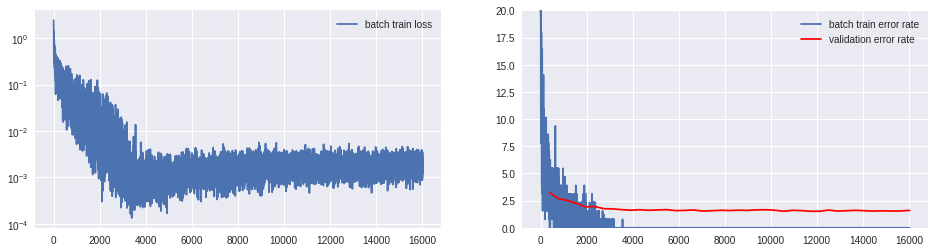

In [0]:
model = FeedforwardNet(
    [
     AffineLayer(784, 1234),
     ReLULayer(),
     AffineLayer(1234, 10),
     SoftMaxLayer()
    ])


with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            psize =  p.size()
            
            p.normal_(0, np.sqrt(2.0/(psize[0]+psize[1])))
            # p.data.uniform_(-0.1, 0.1)
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=0.05,momentum_mi=0.95, lr_schedule = 0.99993, weight_decay=0.0001, device='cuda')
model.eval_mode()
print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  0.28 | err rate  7.03%, steps/s 46.34
Minibatch    200  | loss  0.13 | err rate  4.69%, steps/s 121.91
Minibatch    300  | loss  0.13 | err rate  7.03%, steps/s 176.29
----------------------------------------------------------
After epoch  1 | valid err rate:  3.56% | doing   2 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.06 | err rate  0.78%, steps/s 119.58
Minibatch    500  | loss  0.05 | err rate  0.78%, steps/s 277.31
Minibatch    600  | loss  0.06 | err rate  3.12%, steps/s 353.96
Minibatch    700  | loss  0.13 | err rate  3.12%, steps/s 425.08
----------------------------------------------------------
After epoch  2 | valid err rate:  2.83% | doing   4 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.03 | err rate  0.00%, steps/s 235.10
Minibatch    900  | loss  0.10 | err ra

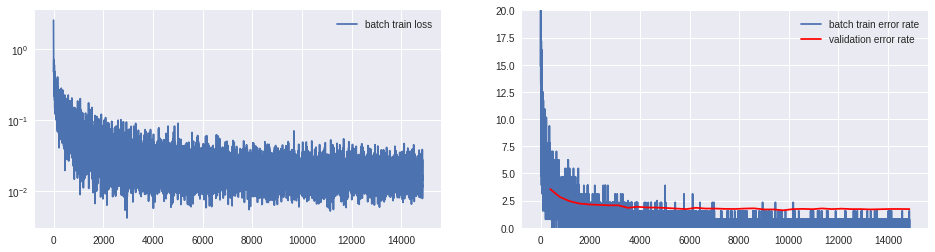

In [0]:
#
# TODO: Pick a network architecture here.
#       The one below is just softmax regression.
#

model = FeedforwardNet(
    [
     AffineLayer(784, 250),
     ReLULayer(),
     AffineLayer(250, 10),
     SoftMaxLayer()
    ])


with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            p.normal_(0, 0.05)
            # p.data.uniform_(-0.1, 0.1)
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=0.1,momentum_mi=0.8, lr_schedule = 0.995, weight_decay=0.001, device='cuda')

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

In [0]:
model.parameters

[('W', tensor([[-0.0082,  0.0095,  0.0054,  ..., -0.0019, -0.0005, -0.0006],
          [ 0.0009,  0.0002, -0.0025,  ..., -0.0082, -0.0195, -0.0083],
          [-0.0058, -0.0090,  0.0037,  ..., -0.0154, -0.0119,  0.0007],
          ...,
          [ 0.0002, -0.0135,  0.0051,  ..., -0.0070,  0.0003,  0.0113],
          [-0.0048, -0.0045, -0.0081,  ...,  0.0042, -0.0051, -0.0030],
          [-0.0042,  0.0065,  0.0074,  ...,  0.0058, -0.0002,  0.0059]],
         requires_grad=True)),
 ('b',
  tensor([[ 0.0098, -0.0057, -0.0024,  0.0055,  0.0043, -0.0001, -0.0138, -0.0048,
           -0.0045,  0.0124,  0.0059, -0.0021, -0.0117,  0.0089, -0.0135, -0.0143,
            0.0113, -0.0077,  0.0024,  0.0179, -0.0230,  0.0005, -0.0208, -0.0019,
           -0.0199, -0.0022,  0.0041,  0.0130, -0.0146,  0.0119, -0.0265, -0.0234,
            0.0105,  0.0094,  0.0035,  0.0078,  0.0107, -0.0002,  0.0030, -0.0132,
           -0.0030, -0.0110,  0.0009, -0.0013, -0.0340, -0.0074,  0.0117,  0.0202,
           

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  0.21 | err rate  4.69%, steps/s 55.05
Minibatch    200  | loss  0.17 | err rate  3.12%, steps/s 113.71
Minibatch    300  | loss  0.13 | err rate  3.12%, steps/s 148.40
----------------------------------------------------------
After epoch  1 | valid err rate:  4.06% | doing   2 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.12 | err rate  5.47%, steps/s 107.92
Minibatch    500  | loss  0.14 | err rate  4.69%, steps/s 240.04
Minibatch    600  | loss  0.03 | err rate  0.78%, steps/s 294.65
Minibatch    700  | loss  0.09 | err rate  3.91%, steps/s 343.42
----------------------------------------------------------
After epoch  2 | valid err rate:  2.94% | doing   4 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.11 | err rate  3.12%, steps/s 206.79
Minibatch    900  | loss  0.09 | err ra

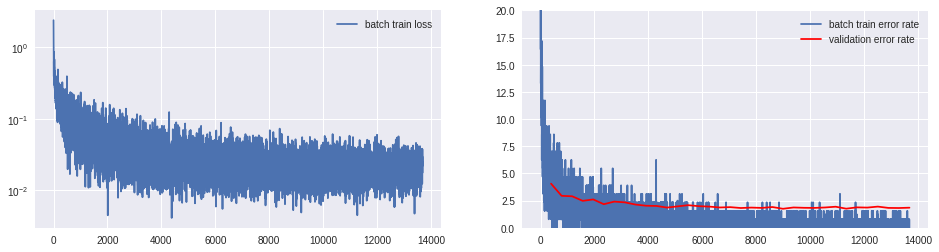

In [0]:
#
# TODO: Pick a network architecture here.
#       The one below is just softmax regression.
#

model = FeedforwardNet(
    [
     AffineLayer(784, 101),
     ReLULayer(),
     AffineLayer(101, 10),
     SoftMaxLayer()
    ])


with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            p.normal_(0, 0.05)
            # p.data.uniform_(-0.1, 0.1)
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=0.1,momentum_mi=0.8, lr_schedule = 0.995, weight_decay=0.001, device='cuda')

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

In [0]:
model.parameters

[('W', tensor([[ 0.0031, -0.0087, -0.0049,  ...,  0.0137, -0.0056, -0.0039],
          [-0.0062, -0.0045,  0.0032,  ...,  0.0189,  0.0028, -0.0038],
          [ 0.0050, -0.0147,  0.0058,  ...,  0.0126,  0.0014,  0.0085],
          ...,
          [ 0.0066, -0.0069,  0.0047,  ..., -0.0001,  0.0096,  0.0012],
          [-0.0031,  0.0053, -0.0054,  ...,  0.0130,  0.0032,  0.0026],
          [-0.0048, -0.0173, -0.0125,  ...,  0.0074, -0.0122, -0.0041]],
         requires_grad=True)),
 ('b',
  tensor([[-0.0384,  0.0247,  0.0093, -0.0062, -0.0287, -0.0476, -0.0022, -0.0007,
           -0.0021, -0.0126, -0.0281, -0.0229, -0.0387, -0.0048, -0.0240,  0.0239,
           -0.0123, -0.0408,  0.0117, -0.0084, -0.0085,  0.0034,  0.0007, -0.0083,
            0.0034,  0.0087,  0.0274,  0.0039, -0.0530,  0.0113, -0.0205,  0.0117,
            0.0170, -0.0355, -0.0123,  0.0033, -0.0286, -0.0267,  0.0013,  0.0370,
           -0.0472,  0.0207,  0.0079, -0.0190, -0.0176, -0.0411,  0.0059, -0.0135,
           

In [0]:
model.parameters

[('W', tensor([[ 0.0027, -0.0013,  0.0052,  ..., -0.0048, -0.0025, -0.0020],
          [ 0.0075,  0.0030,  0.0056,  ..., -0.0048, -0.0020, -0.0046],
          [ 0.0058,  0.0029, -0.0029,  ..., -0.0008,  0.0091, -0.0029],
          ...,
          [ 0.0056, -0.0028,  0.0126,  ..., -0.0093,  0.0125, -0.0116],
          [-0.0029, -0.0021,  0.0009,  ..., -0.0049,  0.0139, -0.0053],
          [ 0.0083,  0.0051, -0.0069,  ..., -0.0069,  0.0070, -0.0050]],
         requires_grad=True)),
 ('b',
  tensor([[-0.0215,  0.0314, -0.0133,  0.0151, -0.0019, -0.0091, -0.0089, -0.0233,
           -0.0049,  0.0205, -0.0080, -0.0077,  0.0242,  0.0161, -0.0069, -0.0072,
            0.0074, -0.0300, -0.0106, -0.0131, -0.0147,  0.0047, -0.0557,  0.0003,
           -0.0224, -0.0434,  0.0048, -0.0742, -0.0254, -0.0245, -0.0169, -0.0339,
            0.0300, -0.0140, -0.0509,  0.0028,  0.0117, -0.0158,  0.0035, -0.0415,
           -0.0149,  0.0002,  0.0300, -0.0105,  0.0426, -0.0722, -0.0060,  0.0369,
           

# Problem 3: Dropout [2p]

Implement a **dropout** layer and try to train a
network getting below 1.5% test error rates with dropout. The best
results with dropout are below 1%!

Remember to turn off dropout during testing, using `model.train_mode()` and `model.eval_mode()`!

Hint: Use [torch.nn.functional.dropout](http://pytorch.org/docs/master/nn.html#torch.nn.functional.dropout).

Details: http://arxiv.org/pdf/1207.0580.pdf.

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100 | alpha 0.04965  | loss  0.48 | err rate 10.94%, steps/s 51.85
Minibatch    200 | alpha 0.04930  | loss  0.31 | err rate 11.72%, steps/s 114.74
Minibatch    300 | alpha 0.04896  | loss  0.47 | err rate 13.28%, steps/s 164.28
----------------------------------------------------------
After epoch  1 | valid err rate:  4.73% | doing   2 epochs
----------------------------------------------------------
Minibatch    400 | alpha 0.04862  | loss  0.30 | err rate  9.38%, steps/s 110.54
Minibatch    500 | alpha 0.04828  | loss  0.48 | err rate  6.25%, steps/s 256.46
Minibatch    600 | alpha 0.04794  | loss  0.22 | err rate  7.03%, steps/s 327.88
Minibatch    700 | alpha 0.04761  | loss  0.41 | err rate 13.28%, steps/s 381.92
----------------------------------------------------------
After epoch  2 | valid err rate:  4.24% | doing   4 epochs
---------------------------------------------------

RuntimeError: ignored

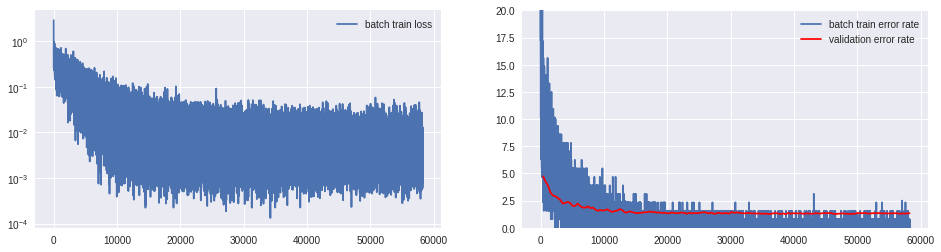

In [0]:
model = FeedforwardNet(
    [
     AffineLayer(784, 1234),
     ReLULayer(),
     AffineLayer(1234, 10,True),
     SoftMaxLayer()
    ])


with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            psize =  p.size()
            
            p.normal_(0, np.sqrt(1.0/(psize[0])))
            # p.data.uniform_(-0.1, 0.1)
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=0.05,momentum_mi=0.95, lr_schedule = 0.99993, weight_decay=0.0001, device='cuda')
model.eval_mode()
print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

In [0]:
compute_error_rate(model, mnist_loaders['test'],device='cuda')

1.46

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100 | alpha 0.04965  | loss  0.55 | err rate 13.28%, steps/s 54.76
Minibatch    200 | alpha 0.04930  | loss  0.39 | err rate 12.50%, steps/s 118.45
Minibatch    300 | alpha 0.04896  | loss  0.26 | err rate 10.94%, steps/s 169.55
----------------------------------------------------------
After epoch  1 | valid err rate:  4.90% | doing   2 epochs
----------------------------------------------------------
Minibatch    400 | alpha 0.04862  | loss  0.08 | err rate  1.56%, steps/s 110.97
Minibatch    500 | alpha 0.04828  | loss  0.22 | err rate  3.91%, steps/s 268.64
Minibatch    600 | alpha 0.04794  | loss  0.13 | err rate  4.69%, steps/s 331.55
Minibatch    700 | alpha 0.04761  | loss  0.26 | err rate  7.81%, steps/s 395.11
----------------------------------------------------------
After epoch  2 | valid err rate:  4.14% | doing   4 epochs
---------------------------------------------------

Process Process-41685:
Traceback (most recent call last):
Process Process-41690:
Process Process-41686:
Process Process-41687:
Process Process-41689:
Process Process-41682:
Process Process-41684:
Process Process-41688:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Process Process-41681:
Process Process-41683:
Traceback (most recent call last):
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr


Loading best params on validation set (epoch 136)



  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py", line 49, in __call__
  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py", line 143, in __call__
    img = self.transform(img)
  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py", line 49, in __call__
  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py", line 76, in __call__
    img = t(img)
    return F.normalize(tensor, self.mean, self.std)
  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py", line 49, in __call__
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 131, in get
    img = self.transform(img)
    return F.to_tensor(pic)
  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py", line 143, in __call__
  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py", line 76, in __call__
    img = t(img)
  F

Test error rate: 1.45%


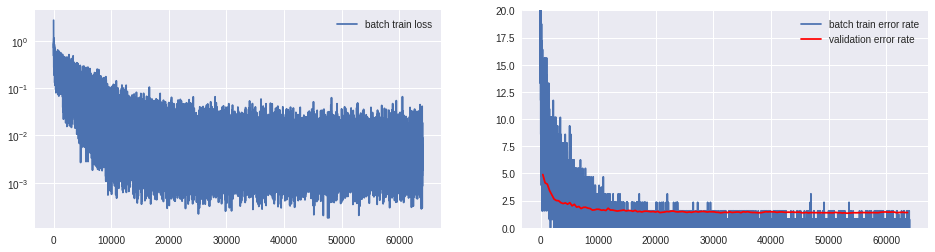

In [0]:
model = FeedforwardNet(
    [
     AffineLayer(784, 1234),
     ReLULayer(),
     DropoutLayer(),
     AffineLayer(1234, 10,False),
     SoftMaxLayer()
    ])


with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            psize =  p.size()
            
            p.normal_(0, np.sqrt(1.0/(psize[0])))
            # p.data.uniform_(-0.1, 0.1)
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=0.05,momentum_mi=0.95, lr_schedule = 0.99993, weight_decay=0.0001, device='cuda')
model.eval_mode()
print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'],device='cuda')

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  0.32 | err rate  8.59%, steps/s 45.60
Minibatch    200  | loss  0.24 | err rate  5.47%, steps/s 109.53
Minibatch    300  | loss  0.20 | err rate  7.81%, steps/s 167.37
----------------------------------------------------------
After epoch  1 | valid err rate:  3.36% | doing   2 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.09 | err rate  3.12%, steps/s 111.12
Minibatch    500  | loss  0.08 | err rate  3.12%, steps/s 281.97
Minibatch    600  | loss  0.04 | err rate  1.56%, steps/s 325.60
Minibatch    700  | loss  0.08 | err rate  3.12%, steps/s 384.05
----------------------------------------------------------
After epoch  2 | valid err rate:  2.96% | doing   4 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.04 | err rate  3.12%, steps/s 219.03
Minibatch    900  | loss  0.03 | err ra

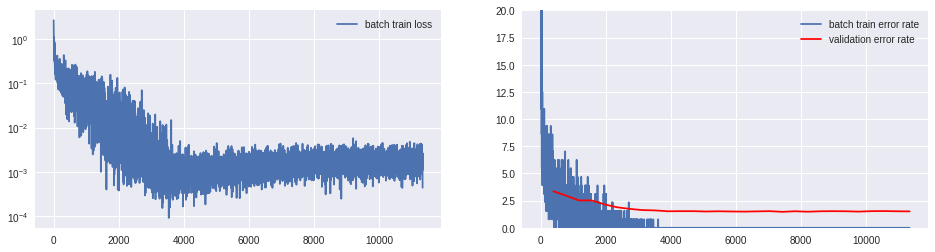

In [0]:
model = FeedforwardNet(
    [
     AffineLayer(784, 1234),
     ReLULayer(),
     AffineLayer(1234, 10),
     SoftMaxLayer()
    ])


with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            psize =  p.size()
            
            p.normal_(0, np.sqrt(2.0/(psize[0]+psize[1])))
            # p.data.uniform_(-0.1, 0.1)
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=0.05,momentum_mi=0.95, lr_schedule = 0.99993, weight_decay=0.0001, device='cuda')
model.eval_mode()
print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

In [0]:
model.parameters

[('W', tensor([[-0.0115, -0.0151, -0.0032,  ..., -0.0015, -0.0017, -0.0055],
          [-0.0152,  0.0182, -0.0116,  ..., -0.0285,  0.0256, -0.0163],
          [ 0.0154,  0.0270,  0.0007,  ..., -0.0291,  0.0162,  0.0105],
          ...,
          [-0.0021,  0.0030,  0.0180,  ...,  0.0346,  0.0129,  0.0014],
          [ 0.0323, -0.0063,  0.0586,  ..., -0.0108, -0.0045, -0.0069],
          [-0.0110,  0.0064, -0.0074,  ..., -0.0140, -0.0104,  0.0203]],
         requires_grad=True)),
 ('b', tensor([[-0.0068, -0.0135, -0.0191,  ..., -0.0063, -0.0145, -0.0125]],
         requires_grad=True)),
 ('W', tensor([[-0.0709,  0.1585,  0.1387,  ...,  0.1047, -0.1164,  0.0294],
          [-0.0305,  0.0259,  0.0358,  ...,  0.0348, -0.0728,  0.1001],
          [-0.0860,  0.0210,  0.0035,  ..., -0.0138,  0.0016,  0.0618],
          ...,
          [ 0.0584, -0.0210,  0.0069,  ...,  0.1487, -0.0701, -0.0569],
          [-0.0125, -0.0331,  0.0549,  ...,  0.1970, -0.1433,  0.0890],
          [ 0.0179, -0.0651

# Problem 4: Data Augmentation [1p]

Apply data augmentation methods (e.g. rotations, noise, crops) when training networks on MNIST, to significantly reduce test error rate for your network. You can use functions from the [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html) module.

In [0]:
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True,transform=torchvision.transforms.Compose([
                       torchvision.transforms.ToTensor(),
                       torchvision.transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [0]:
_train.train_data.data = _train.train_data.data.float()
for i in range(50000):
    _train.train_data.data[i] = transform(_train.train_data[i].data.view(1,28,28)).view(28,28)

In [0]:
transform

Compose(
    ToTensor()
    Normalize(mean=(0.1307,), std=(0.3081,))
)

In [0]:
torch.from_numpy(np.flip(_train.train_data.data,1))


In [0]:
transformation_augmentation = torchvision.transforms.Compose([
                 torchvision.transforms.ToPILImage(),                 
                 torchvision.transforms.ColorJitter(),
                 torchvision.transforms.Resize(33),
                 torchvision.transforms.RandomAffine(0),
                 torchvision.transforms.RandomCrop(28),
                 torchvision.transforms.ToTensor()])

transformation_augmentation2 = torchvision.transforms.Compose([
  #  torchvision.transforms.ToTensor(),
   #  torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                 torchvision.transforms.ToPILImage(),                 
                 torchvision.transforms.ColorJitter(),
                 torchvision.transforms.RandomAffine(0),
                 torchvision.transforms.RandomHorizontalFlip(p=1),
                 torchvision.transforms.ToTensor()
])


_train2 = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)
_train3 = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)


_train2.train_data.data= torch.tensor(np.flip(_train.train_data.data,1).copy())
_train3.train_data.data=torch.tensor(np.flip(_train.train_data.data,2).copy())
#for i in range(50000):
#    _train2.train_data[i] = transformation_augmentation(_train.train_data[i].data.view(1,28,28)).view(28,28).clone()
#    _train3.train_data[i] = transformation_augmentation2(_train.train_data[i].data.view(1,28,28)).view(28,28).clone()


print (_train3.train_data[:50000]).size()
_train.train_data = torch.cat((_train.train_data[:50000], _train3.train_data[:50000]))
_train.train_labels = torch.cat((_train.train_labels[:50000], _train.train_labels[:50000]))
print _train.train_data.size()
print _train.train_labels.size()

mnist_loaders = {
    'train': torch.utils.data.DataLoader(
        _train, batch_size=batch_size, shuffle=True,
        pin_memory=True, num_workers=10),
    'valid': torch.utils.data.DataLoader(
        _valid, batch_size=batch_size, shuffle=False),
    'test': torch.utils.data.DataLoader(
        _test, batch_size=batch_size, shuffle=False)}

In [0]:
plt.imshow(_train3.train_data[0].data)

In [0]:
_train3.train_data.view(-1,28,28).size()

In [0]:
_train3.train_data.data[0]

In [0]:
transformation_augmentation2 = torchvision.transforms.Compose([
  #  torchvision.transforms.ToTensor(),
   #  torchvision.transforms.Normalize((0.1307,), (0.3081,)),
torchvision.transforms.ToPILImage(mode="L"), 
                 torchvision.transforms.RandomHorizontalFlip(p=1),
#torchvision.transforms.ToTensor()
])

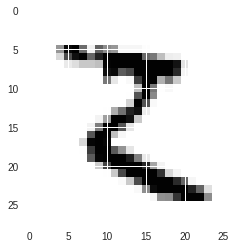

In [0]:
plt.imshow(transformation_augmentation2(_train.train_data[0].data.view(1,28,28)).view(28,28))


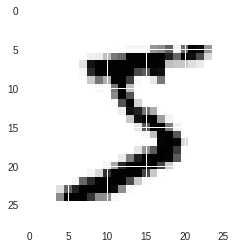

In [0]:
plt.imshow(_train.train_data[0].float())

In [0]:
_train3.train_data[0] = torch.tensor(transformation_augmentation2(_train.train_data[0].data.view(1,28,28)).view(28,28))

In [0]:
plt.imshow(transformation_augmentation2(_train.train_data[0].data.view(1,28,28)).view(28,28))

In [0]:
def plot_augmentation(dataset,index,shift,total_sets):
    for i in range(total_sets):
        plt.subplot(1,total_sets,i+1)
        plt.imshow(dataset[index+i*shift])

In [0]:
asdf = np.random.randint(0,44444)

print asdf
plot_augmentation(_train.train_data,asdf,50000,3)

##zz

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100 | alpha 0.04965  | loss  0.41 | err rate 12.50%, steps/s 43.72
Minibatch    200 | alpha 0.04930  | loss  0.35 | err rate 10.94%, steps/s 99.60
Minibatch    300 | alpha 0.04896  | loss  0.16 | err rate  6.25%, steps/s 141.19
----------------------------------------------------------
After epoch  1 | valid err rate:  5.14% | doing   2 epochs
----------------------------------------------------------
Minibatch    400 | alpha 0.04862  | loss  0.38 | err rate  5.47%, steps/s 92.20
Minibatch    500 | alpha 0.04828  | loss  0.16 | err rate  4.69%, steps/s 222.70
Minibatch    600 | alpha 0.04794  | loss  0.09 | err rate  3.91%, steps/s 296.19
Minibatch    700 | alpha 0.04761  | loss  0.29 | err rate  7.81%, steps/s 337.43
----------------------------------------------------------
After epoch  2 | valid err rate:  3.23% | doing   4 epochs
-----------------------------------------------------

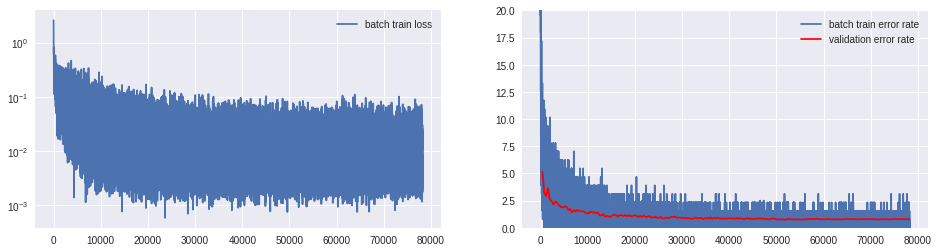

In [0]:

model = FeedforwardNet(
    [
     AffineLayer(784, 1234, dropout=False),
     ReLULayer(),
     AffineLayer(1234, 10, dropout=False),
     SoftMaxLayer()
    ])


with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            psize =  p.size()
            
            p.normal_(0, np.sqrt(2.0/(psize[0]+psize[1])))
            # p.data.uniform_(-0.1, 0.1)
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=0.05,momentum_mi=0.95, lr_schedule = 0.99993, weight_decay=0.0001, device='cuda')
model.eval_mode()
print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

In [0]:
model.parameters

[('W', tensor([[ 0.0022,  0.0035,  0.0151,  ...,  0.0159,  0.0051,  0.0101],
          [ 0.0059, -0.0096, -0.0069,  ...,  0.0301,  0.0122, -0.0073],
          [ 0.0168,  0.0136,  0.0092,  ...,  0.0114,  0.0078,  0.0167],
          ...,
          [ 0.0262, -0.0113,  0.0095,  ...,  0.0297, -0.0112,  0.0019],
          [ 0.0192,  0.0036,  0.0168,  ...,  0.0023,  0.0065,  0.0051],
          [ 0.0314,  0.0071, -0.0022,  ..., -0.0086, -0.0031, -0.0068]],
         requires_grad=True)),
 ('b', tensor([[-0.0661, -0.0677, -0.0380,  ..., -0.1307, -0.0499, -0.0548]],
         requires_grad=True)),
 ('W', tensor([[-0.1759,  0.0783,  0.3366,  ..., -0.3221,  0.0456,  0.0238],
          [-0.0090, -0.1443, -0.0658,  ..., -0.1045,  0.1666, -0.1013],
          [ 0.0271, -0.1122,  0.1271,  ..., -0.0427,  0.0251,  0.1051],
          ...,
          [-0.0132, -0.0008, -0.0287,  ..., -0.0311, -0.0599, -0.1539],
          [ 0.1137,  0.0840, -0.1044,  ..., -0.0314, -0.0627, -0.0601],
          [-0.0279,  0.1482

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100 | alpha 0.04965  | loss  0.41 | err rate 15.62%, steps/s 32.64
Minibatch    200 | alpha 0.04930  | loss  0.17 | err rate  4.69%, steps/s 94.08
Minibatch    300 | alpha 0.04896  | loss  0.26 | err rate  5.47%, steps/s 141.56
----------------------------------------------------------
After epoch  1 | valid err rate:  5.29% | doing   2 epochs
----------------------------------------------------------
Minibatch    400 | alpha 0.04862  | loss  0.27 | err rate  5.47%, steps/s 89.75
Minibatch    500 | alpha 0.04828  | loss  0.29 | err rate  8.59%, steps/s 223.29
Minibatch    600 | alpha 0.04794  | loss  0.13 | err rate  6.25%, steps/s 283.20
Minibatch    700 | alpha 0.04761  | loss  0.13 | err rate  3.12%, steps/s 332.25
----------------------------------------------------------
After epoch  2 | valid err rate:  4.46% | doing   4 epochs
-----------------------------------------------------

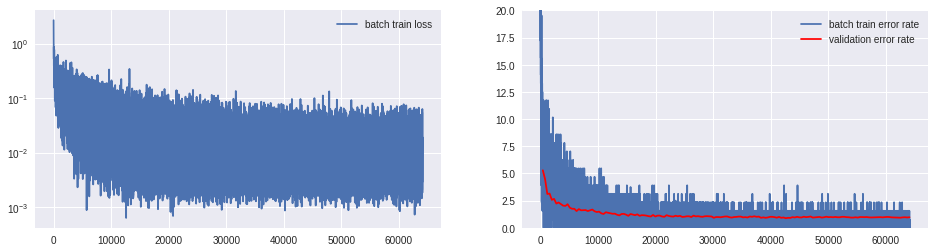

In [0]:

model = FeedforwardNet(
    [
     AffineLayer(784, 1234, dropout=True),
     ReLULayer(),
     AffineLayer(1234, 10, dropout=True),
     SoftMaxLayer()
    ])


with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            psize =  p.size()
            
            p.normal_(0, np.sqrt(2.0/(psize[0]+psize[1])))
            # p.data.uniform_(-0.1, 0.1)
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=0.05,momentum_mi=0.95, lr_schedule = 0.99993, weight_decay=0.0001, device='cuda')
model.eval_mode()
print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

In [0]:
model.parameters

[('W', tensor([[ 0.0169,  0.0346,  0.0049,  ...,  0.0058, -0.0012,  0.0059],
          [-0.0050,  0.0386, -0.0007,  ...,  0.0097, -0.0128,  0.0041],
          [-0.0105,  0.0342,  0.0187,  ...,  0.0061,  0.0082, -0.0090],
          ...,
          [ 0.0228,  0.0165,  0.0035,  ...,  0.0009,  0.0012,  0.0089],
          [ 0.0111,  0.0252,  0.0088,  ..., -0.0025,  0.0058, -0.0042],
          [ 0.0073,  0.0202, -0.0049,  ...,  0.0073,  0.0036,  0.0177]],
         requires_grad=True)),
 ('b', tensor([[-6.3202e-02, -1.9573e-01, -7.0574e-02,  ..., -6.8611e-02,
           -3.8926e-02, -5.6976e-02]], requires_grad=True)),
 ('W', tensor([[-0.1066, -0.0243, -0.0840,  ...,  0.1034, -0.1171,  0.1050],
          [-0.1956, -0.1864,  0.0907,  ...,  0.1802, -0.0019, -0.2222],
          [ 0.0582,  0.2322,  0.0667,  ...,  0.1419, -0.1102, -0.0644],
          ...,
          [ 0.1543,  0.1503, -0.1634,  ...,  0.0182,  0.0331, -0.2960],
          [-0.0092,  0.0238,  0.0777,  ...,  0.0410,  0.0939,  0.0537],
 

# Problem 5: Batch Normalization [1p]

*Covariate shift* is a phenomenon associated with training deep models. Simply put, weight changes in early layers cause major changes in distribution of inputs to later layers, making it difficult to train later layers.

[Batch Normalization](https://arxiv.org/abs/1502.03167) addresses this problem by normalizing distributions of inputs to layers within mini-batches. It typically allows to train networks faster and/or with higher learning rates, lessens the importance
of initialization and might eliminate the need for Dropout.

Implement Batch Normalization and compare with regular training of MNIST models.

Remember to use the batch statistics during model training and to use an average of training batch statistics during model evaluation. For details please consult the paper.

# Problem 6: Norm Constraints [1p bonus]

Implement norm constraints, i.e. instead of weight decay, that tries to set 
all weights to small values, apply a limit on the total
norm of connections incoming to a neuron. In our case, this
corresponds to clipping the norm of *rows* of weight
matrices. An easy way of implementing it is to make a gradient
step, then look at the norm of rows and scale down those that are
over the threshold (this technique is called "projected gradient descent").

Please consult the Dropout paper (http://arxiv.org/pdf/1207.0580.pdf) for details.

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100 | alpha 0.04965  | loss  0.25 | err rate  8.59%, steps/s 35.18
Minibatch    200 | alpha 0.04930  | loss  0.16 | err rate  3.91%, steps/s 83.70
Minibatch    300 | alpha 0.04896  | loss  0.20 | err rate  4.69%, steps/s 124.58
----------------------------------------------------------
After epoch  1 | valid err rate:  3.39% | doing   2 epochs
----------------------------------------------------------
Minibatch    400 | alpha 0.04862  | loss  0.06 | err rate  3.12%, steps/s 83.36
Minibatch    500 | alpha 0.04828  | loss  0.04 | err rate  0.78%, steps/s 209.99
Minibatch    600 | alpha 0.04794  | loss  0.07 | err rate  2.34%, steps/s 249.95
Minibatch    700 | alpha 0.04761  | loss  0.04 | err rate  0.78%, steps/s 293.16
----------------------------------------------------------
After epoch  2 | valid err rate:  3.37% | doing   4 epochs
-----------------------------------------------------

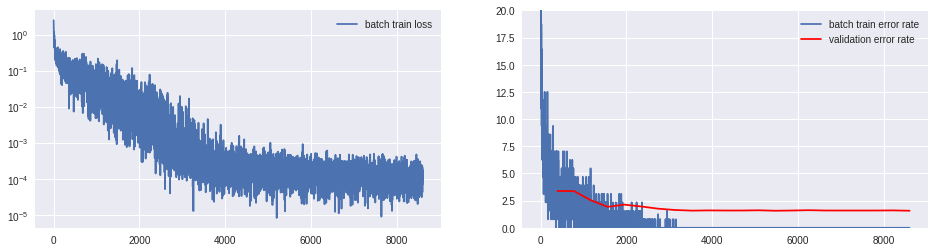

In [0]:
model = FeedforwardNet(
    [
     AffineLayer(784, 1234, dropout=False),
     ReLULayer(),
     AffineLayer(1234, 10, dropout=False),
     SoftMaxLayer()
    ])


with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            psize =  p.size()
            
            p.normal_(0, np.sqrt(2.0/(psize[0]+psize[1])))
            # p.data.uniform_(-0.1, 0.1)
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=0.05,momentum_mi=0.95, lr_schedule = 0.99993, weight_decay=0,c_for_constraint_norm = 3.0, device='cuda')
model.eval_mode()
print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

# Problem 6: Polyak Averaging [1p bonus]

Implement Polyak averaging. For each parameter $\theta$
keep a separate, exponentially decayed average of the past values
$$
\bar{\theta}_n = \alpha_p\bar{\theta}_{n-1} + (1-\alpha_p)\theta_n.
$$
Use that average when evaluating the model on the test set.
Validate the approach by training a model on the MNIST dataset.

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100 | alpha 0.04965  | loss  0.19 | err rate  6.25%, steps/s 29.20
Minibatch    200 | alpha 0.04930  | loss  0.20 | err rate  4.69%, steps/s 113.46
Minibatch    300 | alpha 0.04896  | loss  0.11 | err rate  3.12%, steps/s 170.08
----------------------------------------------------------
After epoch  1 | valid err rate:  4.34% | doing   2 epochs
----------------------------------------------------------
Minibatch    400 | alpha 0.04862  | loss  0.11 | err rate  3.12%, steps/s 115.72
Minibatch    500 | alpha 0.04828  | loss  0.08 | err rate  3.12%, steps/s 272.21
Minibatch    600 | alpha 0.04794  | loss  0.09 | err rate  5.47%, steps/s 338.90
Minibatch    700 | alpha 0.04761  | loss  0.09 | err rate  2.34%, steps/s 393.57
----------------------------------------------------------
After epoch  2 | valid err rate:  2.99% | doing   4 epochs
---------------------------------------------------

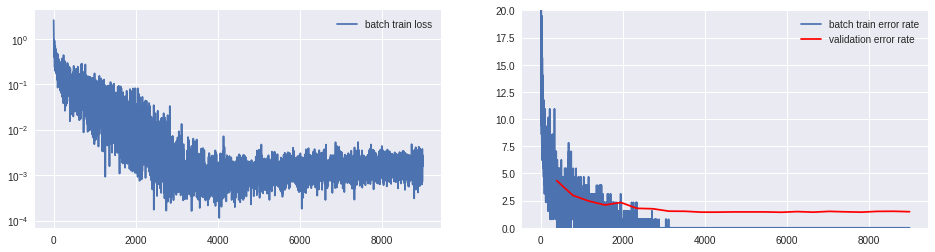

In [0]:
model = FeedforwardNet(
    [
     AffineLayer(784, 1234, dropout=False),
     ReLULayer(),
     AffineLayer(1234, 10, dropout=False),
     SoftMaxLayer()
    ])


with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            psize =  p.size()
            
            p.normal_(0, np.sqrt(2.0/(psize[0]+psize[1])))
            # p.data.uniform_(-0.1, 0.1)
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=0.05,momentum_mi=0.95, lr_schedule = 0.99993, weight_decay=0.0001,polyak_variable=0.95, device='cuda',num_epochs=1, patience_expansion=1.5)
model.eval_mode()
print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

# Problem 7: Convolutional Network [2p bonus]

Use convolutional and max-pooling layers (`torch.nn.functional.conv2d`, `torch.nn.functional.max_pool2d`) and (without dropout) get a test error rate below 1.5%.

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100 | alpha 0.04965  | loss  0.31 | err rate  7.03%, steps/s 43.46
Minibatch    200 | alpha 0.04930  | loss  0.17 | err rate  6.25%, steps/s 98.71
Minibatch    300 | alpha 0.04896  | loss  0.26 | err rate 10.16%, steps/s 145.57
----------------------------------------------------------
After epoch  1 | valid err rate:  3.86% | doing  50 epochs
----------------------------------------------------------
Minibatch    400 | alpha 0.04862  | loss  0.08 | err rate  3.12%, steps/s 98.73
Minibatch    500 | alpha 0.04828  | loss  0.04 | err rate  0.78%, steps/s 237.89
Minibatch    600 | alpha 0.04794  | loss  0.12 | err rate  6.25%, steps/s 297.80
Minibatch    700 | alpha 0.04761  | loss  0.09 | err rate  2.34%, steps/s 346.51
----------------------------------------------------------
After epoch  2 | valid err rate:  4.26% | doing  50 epochs
-----------------------------------------------------

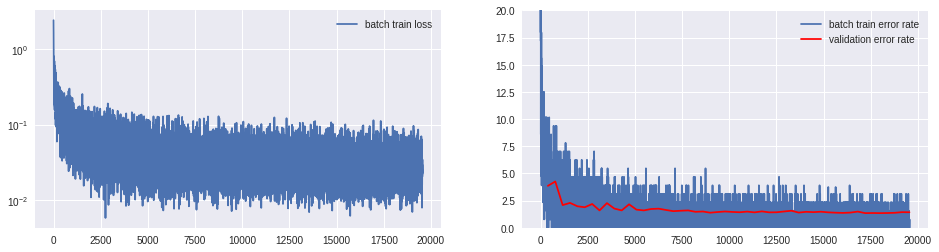

In [0]:
model = FeedforwardNet(
    [
     ConvvLayer(1,32,5,28,28,1,2),
     MaxPoolLayer(2),
     ReLULayer(),
     ConvvLayer(32,64,5,14,14,1,2),
     MaxPoolLayer(2),
     ReLULayer(),
     AffineLayer(3136,10), 
     SoftMaxLayer()
    ])


with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            psize =  p.size()
            p.normal_(0, np.sqrt(1.0/(psize[0])))
            #p.normal_(0, 0.05)
            # p.data.uniform_(-0.1, 0.1)
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders,num_epochs=50, patience_expansion=0, alpha=0.05,momentum_mi=0.95, lr_schedule = 0.99993, weight_decay=0.0001, device='cuda')
model.eval_mode()
print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'],device='cuda')

(self, in_channels, out_channels, kernel_size, x_dim, y_dim, stride=1, padding=0):
x_dim, y_dim,ch,kernel_size):

In [0]:
model = FeedforwardNet(
    [
     RealConvLayer(1,32,5,28,28,1,2),
     RRMaxPoolLayer(28,28,32,2),
     ReLULayer(),
     RealConvLayer(32,64,5,14,14,1,2),
     RRMaxPoolLayer(14,14,64,2),
     ReLULayer(),
     AffineLayer(3136,10), 
     SoftMaxLayer()
    ])


with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            psize =  p.size()
            
            p.normal_(0, 11)
            # p.data.uniform_(-0.1, 0.1)
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders,num_epochs=50, patience_expansion=0, alpha=0.05,momentum_mi=0.95, lr_schedule = 0.99993, weight_decay=0.0001, device='cuda')
model.eval_mode()
print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'],device='cuda')

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100 | alpha 0.04965  | loss   nan | err rate 89.06%, steps/s 37.30
Minibatch    200 | alpha 0.04930  | loss   nan | err rate 86.72%, steps/s 93.37
Minibatch    300 | alpha 0.04896  | loss   nan | err rate 93.75%, steps/s 138.44


RuntimeError: ignored

# Problem 8: Hyperparameter tuner [1p bonus]

Implement a hyper-parameter tuner able to optimize the learing rate schedule, number of neurons and similar hyperparameters. For start, use random search (please see http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf and especially Fig 1. for intuitions on why random search is better than grid search). It may be a good idea to use a fixed maximum number of epochs (or training time) for each optimization trial to prevent selecting hyperparameters that yield slowly converging solutions. A good result will be a set of hyperparameters that reach on MNIST solutions with test errors less than $1.3\%$ in no more than 50 epochs.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def tune_params(T=1000,log_freq=10):
    thresh = 10000
    minimum_val = np.inf
    iteration = 0
    while (T > iteration):
        iteration = iteration+1
        
        alpha = np.random.uniform(0.01,0.1)
        momentum_mi = 1 - alpha
        lr_schedule = np.random.uniform(0.9999,0.99999)
        weight_decay = np.random.uniform(0.0001,0.001)
        hidden_neurons = np.random.randint(100,5000)
        
        model = FeedforwardNet(
    [
     AffineLayer(784, hidden_neurons, dropout=False),
     ReLULayer(),
     AffineLayer(hidden_neurons, 10, dropout=False),
     SoftMaxLayer()
    ])


        with torch.no_grad():
            # Initialize parameters
            for name, p in model.parameters:
                if name == 'W':
                    psize =  p.size()

                    p.normal_(0, np.sqrt(1.0/(psize[0])))
                    # p.data.uniform_(-0.1, 0.1)
                elif name == 'b':
                    p.zero_()
                else:
                    raise ValueError('Unknown parameter name "%s"' % p.name)

        SGD(model, mnist_loaders,log_every=1000000, alpha=alpha,momentum_mi=momentum_mi, lr_schedule = lr_schedule, weight_decay=weight_decay, device='cuda',num_epochs=50, patience_expansion=0,show_plot=False)
        model.eval_mode()
        thresh = compute_error_rate(model, mnist_loaders['test'],device='cuda')
        print thresh
        if(thresh < minimum_val):
            minimum_val = thresh
            print "better result achieved!",thresh, "alpha",alpha,"momentum_mi",momentum_mi,"lr_schedule",lr_schedule,"weight_decay",weight_decay,"hidden_neurons",hidden_neurons
        if(iteration % log_freq == 0):
            print iteration,"-lowest result",minimum_val
            
        if (thresh <= 1.3):
            print "alpha",alpha,"momentum_mi",momentum_mi,"lr_schedule",lr_schedule,"weight_decay",weight_decay,"hidden_neurons",hidden_neurons
            #with open('/content/gdrive/My Drive/foo.txt', 'w') as f:
            #    f.write("alpha "+ str(alpha) + "momentum_mi " + str(momentum_mi) + "lr_schedule " + str(lr_schedule) + "weight_decay " + str(weight_decay)  + "hidden_neurons "+ str(hidden_neurons))
            break
    

In [0]:
tune_params()

Training the model!
Interrupt at any time to evaluate the best validation model so far.
----------------------------------------------------------
After epoch  1 | valid err rate:  3.27% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  2 | valid err rate:  2.98% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  3 | valid err rate:  2.39% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  4 | valid err rate:  2.35% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  5 | valid err rate:  1.93% | doing  50 epochs
----------------------------------------------------------
---------------------------

KeyboardInterrupt: ignored

In [0]:
tune_params()

Training the model!
Interrupt at any time to evaluate the best validation model so far.
----------------------------------------------------------
After epoch  1 | valid err rate:  5.02% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  2 | valid err rate:  2.88% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  3 | valid err rate:  2.49% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  4 | valid err rate:  1.96% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  5 | valid err rate:  1.84% | doing  50 epochs
----------------------------------------------------------
---------------------------

Process Process-36418:
Process Process-36415:
Process Process-36414:
Process Process-36416:
Process Process-36417:
Traceback (most recent call last):
Process Process-36412:
Traceback (most recent call last):
Process Process-36413:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Process Process-36420:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Process Process-36419:
Traceback (most recent call last):
Process Process-36411:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line


Loading best params on validation set (epoch 16)



  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py", line 143, in __call__
  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py", line 49, in __call__
  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py", line 49, in __call__
  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py", line 143, in __call__
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 164, in default_collate
    return F.normalize(tensor, self.mean, self.std)
    img = t(img)
    return F.normalize(tensor, self.mean, self.std)
  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/functional.py", line 167, in normalize
    img = t(img)
  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py", line 76, in __call__
  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/functional.py", line 167, in normaliz

1.78
50 -lowest result 1.33
Training the model!
Interrupt at any time to evaluate the best validation model so far.
----------------------------------------------------------
After epoch  1 | valid err rate:  2.95% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  2 | valid err rate:  2.67% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  3 | valid err rate:  2.21% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  4 | valid err rate:  2.01% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  5 | valid err rate:  1.74% | doing  50 epochs
----------------------------------------------------------

Process Process-36747:
Process Process-36745:
Process Process-36746:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Process Process-36749:
    self.run()
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 110, in _worker_loop
Process Process-36742:
    self.run()
Process Process-36744:
Process Process-36743:
Process Process-36750:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
Process Process-36748:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
    self._target(*self._args, **self._kwargs)
Process Process-36741:
Traceback (most recent call last):
    self._target(*self._args, **self.


Loading best params on validation set (epoch 15)



  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py", line 76, in __call__
    samples = collate_fn([dataset[i] for i in batch_indices])
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python2.7/pickle.py", line 224, in dump
    samples = collate_fn([dataset[i] for i in batch_indices])
    samples = collate_fn([dataset[i] for i in batch_indices])
    img = Image.fromarray(img.numpy(), mode='L')
  File "/usr/local/lib/python2.7/dist-packages/torchvision/datasets/mnist.py", line 77, in __getitem__
  File "/usr/local/lib/python2.7/dist-packages/torchvision/datasets/mnist.py", line 77, in __getitem__
  File "/usr/local/lib/python2.7/dist-packages/torchvision/datasets/mnist.py", line 74, in __getitem__
    return F.to_tensor(pic)
  File "/usr/local/lib/python2.7/dist-packages/torchvision/datasets/mnist.py", line 77, in __getitem__
    img, target = self.train_data[index], self.train_labels[index]
  File "/usr/local/lib/python2.7

1.47
Training the model!
Interrupt at any time to evaluate the best validation model so far.
----------------------------------------------------------
After epoch  1 | valid err rate:  2.87% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  2 | valid err rate:  2.44% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  3 | valid err rate:  2.09% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  4 | valid err rate:  2.00% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  5 | valid err rate:  1.90% | doing  50 epochs
----------------------------------------------------------
----------------------

Process Process-37005:
Process Process-37006:
Process Process-37007:
Process Process-37008:
Process Process-37001:
Process Process-37010:
Process Process-37004:
Process Process-37002:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-37003:
Traceback (most recent call last):
Process Process-37009:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py",


Loading best params on validation set (epoch 14)



    if not self._poll(timeout):
  File "/usr/local/lib/python2.7/dist-packages/torchvision/datasets/mnist.py", line 74, in __getitem__
  File "/usr/local/lib/python2.7/dist-packages/torchvision/datasets/mnist.py", line 77, in __getitem__
    if not self._poll(timeout):
    img = Image.fromarray(img.numpy(), mode='L')
  File "/usr/local/lib/python2.7/dist-packages/torchvision/datasets/mnist.py", line 77, in __getitem__
    img = Image.fromarray(img.numpy(), mode='L')
    return send(obj)
KeyboardInterrupt
    if not self._poll(timeout):
    img = Image.fromarray(img.numpy(), mode='L')
    img = self.transform(img)
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/local/lib/python2.7/dist-packages/torch/multiprocessing/queue.py", line 18, in send
  File "/usr/local/lib/python2.7/dist-packages/PIL/Image.py", line 2511, in fromarray
    img = self.transform(img)
KeyboardInterrupt
  File "/usr/local/lib/python2.7/dist-packages/PIL/Image.py", line 2511, in fromarray
  File "/usr/local/lib/pyt

1.5
Training the model!
Interrupt at any time to evaluate the best validation model so far.
----------------------------------------------------------
After epoch  1 | valid err rate:  3.17% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  2 | valid err rate:  2.56% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  3 | valid err rate:  2.02% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  4 | valid err rate:  1.74% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  5 | valid err rate:  1.70% | doing  50 epochs
----------------------------------------------------------
-----------------------

Process Process-37219:
Process Process-37218:
Process Process-37213:
Process Process-37217:
Process Process-37212:
Process Process-37216:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-37214:
Process Process-37211:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-37215:
Traceback (most recent call last):
Process Process-37220:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/usr/lib/python2.


Loading best params on validation set (epoch 7)



  File "/usr/local/lib/python2.7/dist-packages/torchvision/datasets/mnist.py", line 74, in __getitem__
    return [default_collate(samples) for samples in transposed]
KeyboardInterrupt
  File "/usr/local/lib/python2.7/dist-packages/torchvision/datasets/mnist.py", line 77, in __getitem__
    img = self.transform(img)
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python2.7/dist-packages/PIL/Image.py", line 2484, in fromarray
    if not self._poll(timeout):
  File "/usr/local/lib/python2.7/dist-packages/torchvision/datasets/mnist.py", line 77, in __getitem__
  File "/usr/local/lib/python2.7/dist-packages/torchvision/datasets/mnist.py", line 77, in __getitem__
    img = Image.fromarray(img.numpy(), mode='L')
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 164, in default_collate
    img = self.transform(img)
    img = self.transform(img)
    shape = arr['shape']
  File "/usr/local/lib/python2.7/dist-packages/PIL/Im

1.44
Training the model!
Interrupt at any time to evaluate the best validation model so far.
----------------------------------------------------------
After epoch  1 | valid err rate:  3.63% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  2 | valid err rate:  2.77% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  3 | valid err rate:  2.55% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  4 | valid err rate:  1.98% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  5 | valid err rate:  1.86% | doing  50 epochs
----------------------------------------------------------
----------------------

Process Process-37587:
Process Process-37590:
Traceback (most recent call last):
Process Process-37588:
Process Process-37589:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Process Process-37582:
Process Process-37581:
Traceback (most recent call last):
Traceback (most recent call last):
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
    self.run()
Process Process-37583:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
Process Process-37586:
Traceback (most recent call last):
Process Process-37585:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessin


Loading best params on validation set (epoch 32)



  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py", line 143, in __call__
    img, target = self.train_data[index], self.train_labels[index]
  File "/usr/local/lib/python2.7/dist-packages/PIL/Image.py", line 2504, in fromarray
  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py", line 49, in __call__
    img = t(img)
KeyboardInterrupt
    size = shape[1], shape[0]
    img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
    img = t(img)
    return F.normalize(tensor, self.mean, self.std)
  File "/usr/local/lib/python2.7/dist-packages/PIL/Image.py", line 738, in tobytes
  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py", line 76, in __call__
  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py", line 143, in __call__
KeyboardInterrupt
KeyboardInterrupt
    return F.normalize(tensor, self.mean, self.std)
    e = _getencoder(self.mode, encoder_

1.47
Training the model!
Interrupt at any time to evaluate the best validation model so far.
----------------------------------------------------------
After epoch  1 | valid err rate:  4.47% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  2 | valid err rate:  3.27% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  3 | valid err rate:  2.78% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  4 | valid err rate:  2.49% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  5 | valid err rate:  2.46% | doing  50 epochs
----------------------------------------------------------
----------------------

Process Process-38045:
Process Process-38042:
Process Process-38050:
Process Process-38047:
Traceback (most recent call last):
Process Process-38043:
Process Process-38041:
Exception KeyboardInterrupt in <bound method StorageRef.__del__ of <torch.multiprocessing.reductions.StorageRef object at 0x7f627a82b250>> ignored
Traceback (most recent call last):
Process Process-38048:
Process Process-38049:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-38044:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/mult


Loading best params on validation set (epoch 29)



  File "/usr/local/lib/python2.7/dist-packages/torchvision/datasets/mnist.py", line 77, in __getitem__
    img = self.transform(img)
    self.save(obj)
    return torch.stack(batch, 0, out=out)
KeyboardInterrupt
  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py", line 49, in __call__
    img = t(img)
  File "/usr/lib/python2.7/pickle.py", line 286, in save
  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py", line 76, in __call__
    f(self, obj) # Call unbound method with explicit self
    return F.to_tensor(pic)
  File "/usr/lib/python2.7/pickle.py", line 554, in save_tuple
    img = self.transform(img)
    save(element)
  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/functional.py", line 70, in to_tensor
    img = Image.fromarray(img.numpy(), mode='L')
  File "/usr/local/lib/python2.7/dist-packages/torchvision/datasets/mnist.py", line 77, in __getitem__
    img = torch.ByteTensor(torch.ByteStorag

1.61
Training the model!
Interrupt at any time to evaluate the best validation model so far.
----------------------------------------------------------
After epoch  1 | valid err rate:  4.01% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  2 | valid err rate:  2.96% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  3 | valid err rate:  2.62% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  4 | valid err rate:  2.49% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  5 | valid err rate:  2.39% | doing  50 epochs
----------------------------------------------------------
----------------------

Process Process-38555:
Process Process-38559:
Process Process-38553:
Process Process-38558:
Process Process-38556:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Process Process-38554:
Process Process-38557:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Process Process-38560:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
Traceback (most recent call last):
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-38551:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/mul

KeyboardInterrupt: ignored